In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize # For optimization challenge
import time

In [4]:
# Asset Selection (Task 1 Requirement: At least 10 diverse assets)

tickers_config = [
    'SPY',    # US Large Cap Stock ETF (S&P 500)
    'EFA',    # Developed Markets (ex-US/Canada) Stock ETF
    'EEM',    # Emerging Markets Stock ETF
    'AGG',    # US Aggregate Bond ETF
    'TIP',    # US TIPS Bond ETF (Inflation-Protected)
    'GLD',    # Gold ETF
    'VNQ',    # US Real Estate ETF
    'AAPL',   # Example Tech Stock
    'JNJ',    # Example Healthcare Stock
    'BTC-USD',# Bitcoin
]
if len(tickers_config) < 10:
    print(f"Warning: Only {len(tickers_config)} assets selected, requirement is at least 10.")

# Time Period (Task 1 Requirement: 10-year period)
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

# Risk-Free Rate Ticker (Task 4 Requirement: e.g., 3-month Treasury yield)
# ^IRX = 13 Week Treasury Bill Yield (Annualized Percentage)
rf_ticker = '^IRX'


# Portfolio Weights (Task 3 Requirement: Assign weights summing to 1)
# Define weights for the initial list in tickers_config

custom_weights = {
    'SPY': 0.15,  'EFA': 0.10, 'EEM': 0.05, 'AGG': 0.20, 'TIP': 0.10,
    'GLD': 0.10,  'VNQ': 0.05, 'AAPL': 0.05, 'JNJ': 0.05, 'BTC-USD': 0.15
    #'ETH-USD': 0.05 # Add weight if ticker is added above
}
# Validation: Check if weights sum to 1 initially
if abs(sum(custom_weights.values()) - 1.0) > 1e-6:
    raise ValueError("Custom weights dictionary values do not sum to 1!")
# Validation: Check if all weighted tickers are in the config list
if not all(ticker in tickers_config for ticker in custom_weights):
     print("Warning: Not all tickers in custom_weights are present in the initial tickers_config list.")

# --- Download Configuration ---
DOWNLOAD_DELAY = 2.0
MAX_RETRIES = 3
RETRY_DELAY = 5.0

In [5]:

print("--- 1. Data Acquisition ---")
print(f"Requesting data for {len(tickers_config)} assets from {start_date.date()} to {end_date.date()}")

asset_adj_close_data = {}
asset_close_data = {} # To store unadjusted close prices
failed_tickers = []
original_tickers = list(tickers_config) # Keep original list for weight mapping
tickers_to_process = list(tickers_config) # Copy to iterate over

# Download asset data sequentially with retries
for ticker in tickers_to_process:
    retries = 0
    success = False
    while retries < MAX_RETRIES and not success:
        print(f"  Attempting download: {ticker} (Try {retries + 1}/{MAX_RETRIES})...")
        try:

            data_single = yf.download(
                ticker, start=start_date, end=end_date, interval='1d',
                progress=False, auto_adjust=False
            )


            if data_single.empty:
                print(f"  Warning: No data returned for {ticker} on try {retries + 1}.")
            elif 'Adj Close' not in data_single.columns or 'Close' not in data_single.columns:
                 print(f"  Warning: Missing 'Adj Close' or 'Close' for {ticker} on try {retries + 1}. Columns: {data_single.columns}")
            else:
                asset_adj_close_data[ticker] = data_single['Adj Close']
                asset_close_data[ticker] = data_single['Close']
                print(f"  Successfully downloaded {ticker} (Adj Close & Close).")
                success = True

            print(f"  Pausing for {DOWNLOAD_DELAY} seconds...")
            time.sleep(DOWNLOAD_DELAY)

        except Exception as e:
            print(f"  ERROR downloading {ticker} on try {retries + 1}: {e}")
            if "YFRateLimitError" in str(e) or "Too Many Requests" in str(e):
                 wait_time = RETRY_DELAY * (retries + 1)
                 print(f"  Rate limit likely hit. Waiting for {wait_time} seconds before retry...")
                 time.sleep(wait_time)
            else:
                 print(f"  Waiting for {RETRY_DELAY} seconds before retry...")
                 time.sleep(RETRY_DELAY)

        if not success:
            retries += 1

    if not success:
        print(f"  Failed to download {ticker} after {MAX_RETRIES} attempts.")
        failed_tickers.append(ticker)


# --- Post-Download Asset Data Processing ---
adj_close_prices = pd.DataFrame()
close_prices = pd.DataFrame()
tickers = []
weights = np.array([])
n_assets = 0

if asset_adj_close_data:
    adj_close_prices = pd.concat(asset_adj_close_data, axis=1)
    close_prices = pd.concat(asset_close_data, axis=1)
    adj_close_prices = adj_close_prices.reindex(sorted(adj_close_prices.columns), axis=1)
    close_prices = close_prices.reindex(sorted(close_prices.columns), axis=1)

    successful_tickers = list(adj_close_prices.columns)
    successful_tickers = [col[0] if isinstance(col, tuple) else col for col in successful_tickers]
    print(f"\nSuccessfully downloaded data for: {', '.join(successful_tickers)}")
    tickers = successful_tickers
    n_assets = len(tickers)

    if failed_tickers:
        print(f"Failed to download data for: {', '.join(failed_tickers)}")
        print("Adjusting portfolio configuration...")
    else:
        print("All initially requested tickers downloaded successfully.")

    weights = np.array([custom_weights.get(ticker, 0) for ticker in tickers])
    if weights.sum() > 1e-6 :
        weights = weights / weights.sum()
        print(f"Final portfolio weights (normalized for {n_assets} successful assets):")

        weights_series = pd.Series(weights, index=tickers)
        print(weights_series.map('{:.2%}'.format))

    else:
        print("Error: Sum of weights for successfully downloaded tickers is zero. Cannot proceed.")
        exit()
    if len(weights) != n_assets:
         print("Error: Mismatch between final weights length and successful ticker count.")
         exit()
else:
    print("Error: Failed to download data for ANY assets. Exiting.")
    exit()


--- 1. Data Acquisition ---
Requesting data for 10 assets from 2015-05-07 to 2025-05-04
  Attempting download: SPY (Try 1/3)...
  Successfully downloaded SPY (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: EFA (Try 1/3)...
  Successfully downloaded EFA (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: EEM (Try 1/3)...
  Successfully downloaded EEM (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: AGG (Try 1/3)...
  Successfully downloaded AGG (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: TIP (Try 1/3)...
  Successfully downloaded TIP (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: GLD (Try 1/3)...
  Successfully downloaded GLD (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: VNQ (Try 1/3)...
  Successfully downloaded VNQ (Adj Close & Close).
  Pausing for 2.0 seconds...
  Attempting download: AAPL (Try 1/3)...
  Successfully downloaded AAPL 

In [6]:
# --- Download Risk-Free Rate Data ---
print(f"\nDownloading risk-free rate ({rf_ticker})...")
rf_data = pd.DataFrame()
rf_rate = pd.Series(dtype=float)
rf_success = False
rf_retries = 0
while rf_retries < MAX_RETRIES and not rf_success:
    # Add a small delay before the first attempt for RF rate
    if rf_retries > 0: print(f"  Attempting download: {rf_ticker} (Try {rf_retries + 1}/{MAX_RETRIES})...")
    else: print(f"  Attempting download: {rf_ticker} (Try 1/{MAX_RETRIES})...")

    try:
        rf_data = yf.download(rf_ticker, start=start_date, end=end_date, interval='1d',
                              progress=False, auto_adjust=False)
        # Use Adj Close for yield, as Close might be missing for indices sometimes
        if rf_data.empty or 'Adj Close' not in rf_data.columns:
            print(f"  Warning: Could not download or find 'Adj Close' for {rf_ticker} (Try {rf_retries + 1}).")
        else:
            rf_rate = rf_data['Adj Close'].ffill() / 100.0 # Convert percentage to decimal
            print(f"  Successfully downloaded risk-free rate {rf_ticker}.")
            rf_success = True
        print(f"  Pausing for {DOWNLOAD_DELAY} seconds...")
        time.sleep(DOWNLOAD_DELAY)
    except Exception as e:
        print(f"  Warning: Error downloading {rf_ticker} (Try {rf_retries + 1}): {e}.")
        # Decide on retry delay based on error type
        if "YFRateLimitError" in str(e) or "Too Many Requests" in str(e):
            wait_time = RETRY_DELAY * (rf_retries + 1)
            print(f"  Rate limit likely hit. Waiting {wait_time} sec...")
            time.sleep(wait_time)
        else:
            print(f"  Waiting {RETRY_DELAY} sec...")
            time.sleep(RETRY_DELAY)
    if not rf_success:
        rf_retries += 1

if not rf_success:
     print(f"Failed to download risk-free rate after {MAX_RETRIES} attempts. Using 0% as fallback.")
     # Create series of zeros aligned with asset index
     rf_rate = pd.Series(0.0, index=adj_close_prices.index)
else:
    # Ensure alignment with asset data index if download was successful
    rf_rate = rf_rate.reindex(adj_close_prices.index)

# Final fill/backfill for RF rate after potential reindexing
rf_rate = rf_rate.ffill().bfill().fillna(0.0)


print("\n--- Data Acquisition Complete ---")
print("Adjusted Close Prices Head:")
print(adj_close_prices.head())
print("\nUnadjusted Close Prices Head (for reference):")
print(close_prices.head())
print("\nRisk-Free Rate (Annualized % Yield / 100) Head:")
print(rf_rate.head())


  Attempting download: ^IRX (Try 1/3)...
  Successfully downloaded risk-free rate ^IRX.
  Pausing for 2.0 seconds...

--- Data Acquisition Complete ---
Adjusted Close Prices Head:
                 AAPL        AGG     BTC-USD        EEM        EFA  \
Ticker           AAPL        AGG     BTC-USD        EEM        EFA   
Date                                                                 
2015-05-07  28.090874  84.625031  237.334000  33.942314  49.500233   
2015-05-08  28.620127  84.902168  243.863007  34.375305  50.645493   
2015-05-09        NaN        NaN  241.832001        NaN        NaN   
2015-05-10        NaN        NaN  240.296005        NaN        NaN   
2015-05-11  28.328592  84.363297  242.158005  34.046543  50.203850   

                   GLD        JNJ         SPY        TIP        VNQ  
Ticker             GLD        JNJ         SPY        TIP        VNQ  
Date                                                                 
2015-05-07  113.419998  75.548035  175.737671  8

In [7]:

print("\n--- 2. Data Cleaning and Preparation ---")

# Focus on 'Adj Close' for returns calculation as it accounts for corporate actions
data_to_clean = adj_close_prices.copy()

# Task 2 Requirement: Handle missing data
initial_nan_count = data_to_clean.isnull().sum().sum()
print(f"Initial NaN count in Adj Close: {initial_nan_count}")

# Define threshold for interpolation (Task 2 Suggestion: minor gaps)
max_consecutive_nan_interpolate = 5

# Interpolate minor gaps (Task 2 Method 1)
data_interp = data_to_clean.interpolate(method='time', limit=max_consecutive_nan_interpolate,
                                          limit_direction='forward', limit_area=None)
nans_after_interp = data_interp.isnull().sum().sum()
print(f"NaNs remaining after time interpolation (limit {max_consecutive_nan_interpolate}): {nans_after_interp}")

# Handle remaining gaps (Task 2 Method 2: forward-fill or drop if > threshold)
# Forward-fill first, as it's often preferred to maintain data continuity
data_ffill = data_interp.fillna(method='ffill')
nans_after_ffill = data_ffill.isnull().sum().sum()
print(f"NaNs remaining after forward fill: {nans_after_ffill}")

# Backfill any remaining NaNs (usually only at the very start)
data_cleaned = data_ffill.fillna(method='bfill')
final_nan_count = data_cleaned.isnull().sum().sum()
print(f"NaNs remaining after back fill: {final_nan_count}")

# Drop rows if any NaNs still persist (e.g., entire row was NaN initially)
if final_nan_count > 0:
    print(f"\nWarning: {final_nan_count} NaNs remain after cleaning steps. Rows containing NaNs will be dropped.")
    print(data_cleaned.isnull().sum())
    initial_rows = len(data_cleaned)
    data_cleaned = data_cleaned.dropna()
    print(f"Dropped {initial_rows - len(data_cleaned)} rows.")
    # IMPORTANT: Re-align rf_rate if rows were dropped
    rf_rate = rf_rate.reindex(data_cleaned.index).ffill().bfill().fillna(0.0)

# Task 2 Requirement: Adjust prices for corporate actions (splits, dividends)
# This is achieved by using the 'Adj Close' prices from yfinance.
print("\nUsing 'Adj Close' prices inherently accounts for stock splits and cash dividends.")
print("No further manual adjustment for corporate actions is needed on this column.")

print("\nCleaned Adjusted Close Prices Head:")
print(data_cleaned.head())
print(f"Final Data Shape: {data_cleaned.shape}")


--- 2. Data Cleaning and Preparation ---
Initial NaN count in Adj Close: 10242
NaNs remaining after time interpolation (limit 5): 0
NaNs remaining after forward fill: 0
NaNs remaining after back fill: 0

Using 'Adj Close' prices inherently accounts for stock splits and cash dividends.
No further manual adjustment for corporate actions is needed on this column.

Cleaned Adjusted Close Prices Head:
                 AAPL        AGG     BTC-USD        EEM        EFA  \
Ticker           AAPL        AGG     BTC-USD        EEM        EFA   
Date                                                                 
2015-05-07  28.090874  84.625031  237.334000  33.942314  49.500233   
2015-05-08  28.620127  84.902168  243.863007  34.375305  50.645493   
2015-05-09  28.522949  84.722544  241.832001  34.265718  50.498278   
2015-05-10  28.425770  84.542920  240.296005  34.156130  50.351064   
2015-05-11  28.328592  84.363297  242.158005  34.046543  50.203850   

                   GLD        JNJ     

C:\Users\omesh\AppData\Local\Temp\ipykernel_7920\2963001743.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data_interp.fillna(method='ffill')
C:\Users\omesh\AppData\Local\Temp\ipykernel_7920\2963001743.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_cleaned = data_ffill.fillna(method='bfill')


In [8]:

print("\n--- 3. Portfolio Construction ---")

# Task 3 Requirement: Calculate daily portfolio returns based on weights and adjusted closing prices.
# Calculate daily percentage returns from the cleaned adjusted closing prices
daily_returns = data_cleaned.pct_change()

# Drop the first row of NaNs created by pct_change()
daily_returns = daily_returns.dropna()

if daily_returns.empty:
     print("Error: Daily returns DataFrame is empty after cleaning and pct_change. Check data integrity.")
     exit()

# Align rf_rate index to match daily_returns index *after* dropna
rf_rate = rf_rate.reindex(daily_returns.index).ffill().bfill().fillna(0.0)
# Calculate daily risk-free rate
trading_days_per_year = 252 # Common assumption
daily_rf_rate = rf_rate / trading_days_per_year

# Ensure weights array and daily_returns columns match before calculation
if len(weights) != len(daily_returns.columns):
     print(f"Error: Weight count ({len(weights)}) != Column count ({len(daily_returns.columns)}) before portfolio return calculation.")
     print("Adjusting weights based on available columns...")
     tickers = daily_returns.columns.tolist()
     weights = np.array([custom_weights.get(t, 0) for t in tickers])
     if weights.sum() > 1e-6: weights = weights / weights.sum()
     else: print("Error: Cannot proceed with zero sum weights."); exit()
     print("Re-aligned weights based on available return columns.")
     if len(weights) != len(daily_returns.columns): print("Error: Still mismatched after re-align."); exit()


# Calculate daily portfolio return as weighted sum of individual asset returns
portfolio_daily_returns = (daily_returns * weights).sum(axis=1)

# Task 3 Requirement: Create a DataFrame representing the portfolio (for analysis)
# We store the daily returns in a portfolio analysis DataFrame
portfolio_analysis = pd.DataFrame({
    'Portfolio Daily Return': portfolio_daily_returns
})

print("\nPortfolio Daily Returns Calculated (Head):")
print(portfolio_analysis.head())





--- 3. Portfolio Construction ---

Portfolio Daily Returns Calculated (Head):
            Portfolio Daily Return
Date                              
2015-05-08                0.013159
2015-05-09               -0.003286
2015-05-10               -0.002995
2015-05-11               -0.000885
2015-05-12               -0.000691


In [9]:

print("\n--- 4. Performance Metrics Calculation ---")
print(f"Metrics calculated from {daily_returns.index.min().date()} to {daily_returns.index.max().date()}")

# Task 4 Metric: Cumulative Return
portfolio_analysis['Cumulative Return'] = (1 + portfolio_analysis['Portfolio Daily Return']).cumprod()
# Normalize starting value to 1 for easier interpretation
portfolio_analysis['Cumulative Return'] = portfolio_analysis['Cumulative Return'] / portfolio_analysis['Cumulative Return'].iloc[0]
total_cumulative_return = portfolio_analysis['Cumulative Return'].iloc[-1] - 1

# Task 4 Metric: Annualized Return and Volatility
n_years = len(portfolio_analysis) / trading_days_per_year
# Geometric Annualized Return (more accurate for multi-period)
annualized_return = (portfolio_analysis['Cumulative Return'].iloc[-1])**(1/n_years) - 1
# Annualized Volatility (Standard Deviation of daily returns)
annualized_volatility = portfolio_analysis['Portfolio Daily Return'].std() * np.sqrt(trading_days_per_year)

# Task 4 Metric: Sharpe Ratio
# Use average annualized risk-free rate over the period
# Get the numeric value instead of a Series
avg_annualized_rf = rf_rate.mean().iloc[0]

# Calculate Sharpe Ratio (Using Geometric Return)
sharpe_ratio = (annualized_return - avg_annualized_rf) / annualized_volatility

# Task 4 Metric: Drawdown Analysis (Max Drawdown and Duration)
portfolio_analysis['Cumulative High'] = portfolio_analysis['Cumulative Return'].cummax()
portfolio_analysis['Drawdown'] = (portfolio_analysis['Cumulative Return'] / portfolio_analysis['Cumulative High']) - 1
max_drawdown = portfolio_analysis['Drawdown'].min()

# Calculate Drawdown Duration (Time from peak to recovery)
try:
    drawdown_series = portfolio_analysis['Drawdown']
    start_date_max_dd = drawdown_series.idxmin()
    peak_date_before_max_dd = portfolio_analysis['Cumulative Return'][:start_date_max_dd].idxmax()
    peak_value = portfolio_analysis['Cumulative Return'][peak_date_before_max_dd]

    recovery_df = portfolio_analysis['Cumulative Return'][start_date_max_dd:]
    recovery_date_candidates = recovery_df[recovery_df >= peak_value]

    if not recovery_date_candidates.empty:
        recovery_date = recovery_date_candidates.idxmin()
        drawdown_duration_days = (recovery_date - peak_date_before_max_dd).days
        drawdown_duration_str = f"{drawdown_duration_days} days (Peak {peak_date_before_max_dd.date()} -> Recovery {recovery_date.date()})"
    else:

        time_in_drawdown = portfolio_analysis.index[-1] - peak_date_before_max_dd
        drawdown_duration_str = f"Not Recovered Yet (In Drawdown for {time_in_drawdown.days} days since {peak_date_before_max_dd.date()})"

except Exception as e:
    print(f"Error calculating drawdown duration: {e}")
    drawdown_duration_str = "Calculation Error"
    peak_date_before_max_dd = pd.NaT
    start_date_max_dd = pd.NaT


# --- Display Performance Metrics ---
metrics_data = {
    'Total Cumulative Return': f"{total_cumulative_return:.2%}",
    'Annualized Return (Geometric)': f"{annualized_return:.2%}",
    'Annualized Volatility': f"{annualized_volatility:.2%}",
    'Average Annualized RFR': f"{avg_annualized_rf:.2%}",
    'Sharpe Ratio': f"{sharpe_ratio:.2f}",
    'Maximum Drawdown': f"{max_drawdown:.2%}",
    'Max Drawdown Peak Date': peak_date_before_max_dd.date() if pd.notna(peak_date_before_max_dd) else 'N/A',
    'Max Drawdown Trough Date': start_date_max_dd.date() if pd.notna(start_date_max_dd) else 'N/A',
    'Max Drawdown Duration': drawdown_duration_str
}
metrics_summary = pd.DataFrame(metrics_data.items(), columns=['Metric', 'Value'])
print("\n--- Portfolio Performance Metrics ---")
print(metrics_summary.set_index('Metric'))


--- 4. Performance Metrics Calculation ---
Metrics calculated from 2015-05-08 to 2025-05-04

--- Portfolio Performance Metrics ---
                                                                           Value
Metric                                                                          
Total Cumulative Return                                                  495.54%
Annualized Return (Geometric)                                             13.11%
Annualized Volatility                                                     11.67%
Average Annualized RFR                                                     1.90%
Sharpe Ratio                                                                0.96
Maximum Drawdown                                                         -28.15%
Max Drawdown Peak Date                                                2021-11-08
Max Drawdown Trough Date                                              2022-11-09
Max Drawdown Duration          836 days (Peak 2021-11-08 -

In [10]:

print("\n--- 5. Correlation and Risk Analysis ---")

# Task 5 Requirement: Create a correlation matrix of assets using daily returns
# Ensure daily_returns is not empty before calculating correlation
if daily_returns.empty:
    print("Warning: Daily returns data is empty. Cannot calculate correlations.")
    correlation_matrix = pd.DataFrame() # Assign empty DataFrame
    rolling_corr_data = {} # Initialize empty dictionary
else:
    correlation_matrix = daily_returns.corr()
    print("\nAsset Daily Return Correlation Matrix:")
    # Display rounded matrix for better readability
    print(correlation_matrix.round(3))

    # Task 5 Requirement: Perform a rolling correlation analysis
    window_corr = 90 # Approx 4 months rolling window
    # Calculate rolling correlation for a few key pairs (if assets exist)
    rolling_corr_data = {} # Store the calculated series here
    key_pairs = [('SPY', 'AGG'), ('SPY', 'GLD'), ('SPY', 'BTC-USD'), ('AGG', 'GLD')]
    print(f"\nCalculating {window_corr}-Day Rolling Correlations...")

    for asset1, asset2 in key_pairs:
        pair_label = f'{asset1} vs {asset2}'
        # Check if both assets exist in the daily returns columns
        if asset1 in daily_returns.columns and asset2 in daily_returns.columns:
            try:
                # Calculate rolling correlation
                rolling_corr = daily_returns[asset1].rolling(window=window_corr).corr(daily_returns[asset2])

                # Check if the resulting series contains any valid (non-NaN) data
                # Need at least 'window_corr' overlapping data points for the first value
                if rolling_corr.notna().sum() > 0:
                    rolling_corr_data[pair_label] = rolling_corr
                    print(f"  Calculated for {pair_label} (Tail):")
                    # Display tail of the *valid* data points
                    print(rolling_corr.dropna().tail(3))
                else:
                    # This happens if there are fewer than 'window_corr' overlapping non-NaN points throughout the series
                    print(f"  Skipping {pair_label}: Not enough overlapping data points for the {window_corr}-day window.")

            except Exception as e:
                print(f"  Error calculating rolling correlation for {pair_label}: {e}")
        else:
            # Message if one or both assets were not successfully downloaded or included
            print(f"  Skipping {pair_label}: Asset '{asset1 if asset1 not in daily_returns.columns else asset2}' not found in returns data.")

# Ensure rolling_corr_data exists even if daily_returns was empty initially
if 'rolling_corr_data' not in locals():
    rolling_corr_data = {}


--- 5. Correlation and Risk Analysis ---

Asset Daily Return Correlation Matrix:
                  AAPL    AGG BTC-USD    EEM    EFA    GLD    JNJ    SPY  \
Ticker            AAPL    AGG BTC-USD    EEM    EFA    GLD    JNJ    SPY   
        Ticker                                                             
AAPL    AAPL     1.000  0.102   0.162  0.560  0.598  0.048  0.325  0.759   
AGG     AGG      0.102  1.000   0.094  0.146  0.178  0.363  0.040  0.132   
BTC-USD BTC-USD  0.162  0.094   1.000  0.174  0.199  0.084  0.061  0.206   
EEM     EEM      0.560  0.146   0.174  1.000  0.835  0.188  0.334  0.750   
EFA     EFA      0.598  0.178   0.199  0.835  1.000  0.158  0.413  0.853   
GLD     GLD      0.048  0.363   0.084  0.188  0.158  1.000  0.043  0.071   
JNJ     JNJ      0.325  0.040   0.061  0.334  0.413  0.043  1.000  0.486   
SPY     SPY      0.759  0.132   0.206  0.750  0.853  0.071  0.486  1.000   
TIP     TIP      0.034  0.759   0.051  0.072  0.087  0.389 -0.020  0.043   
VNQ   


--- 6. Advanced Data Visualization ---


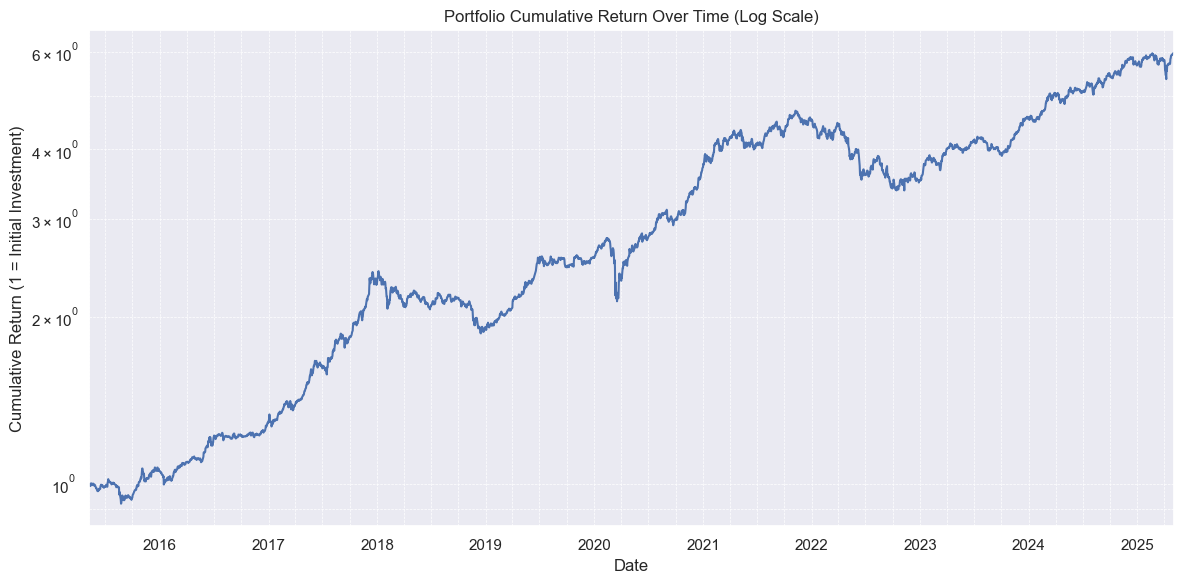

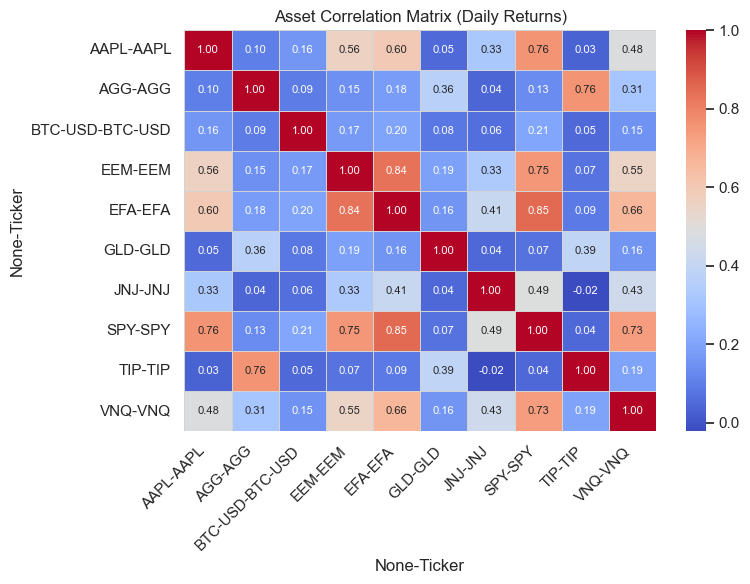

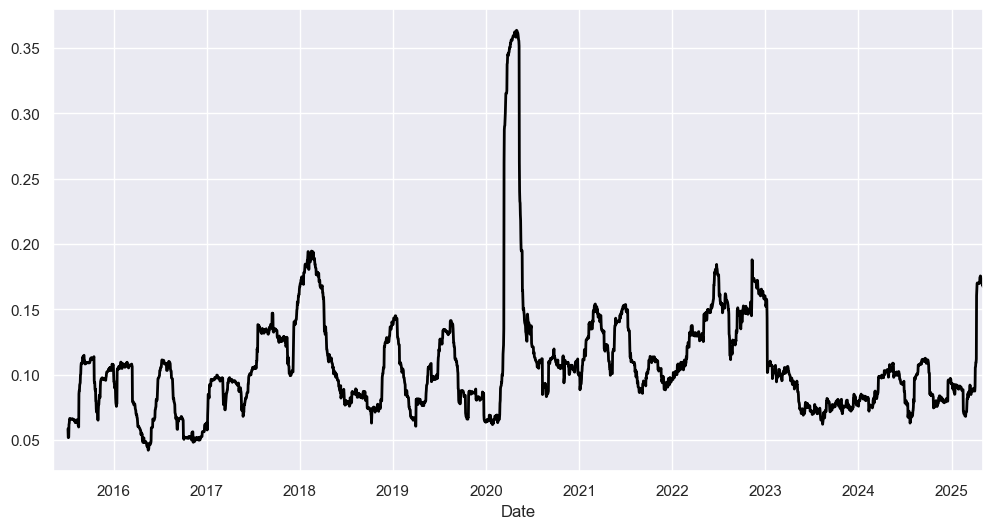

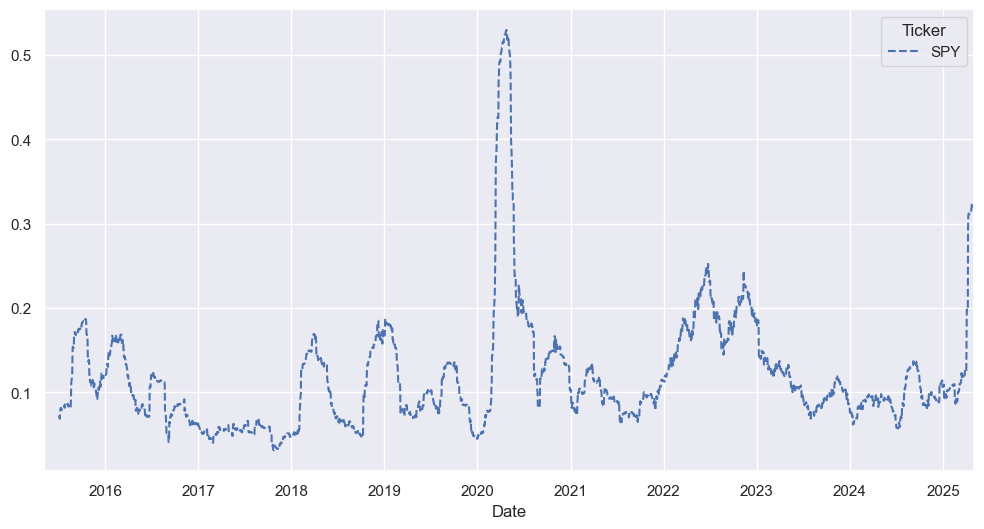

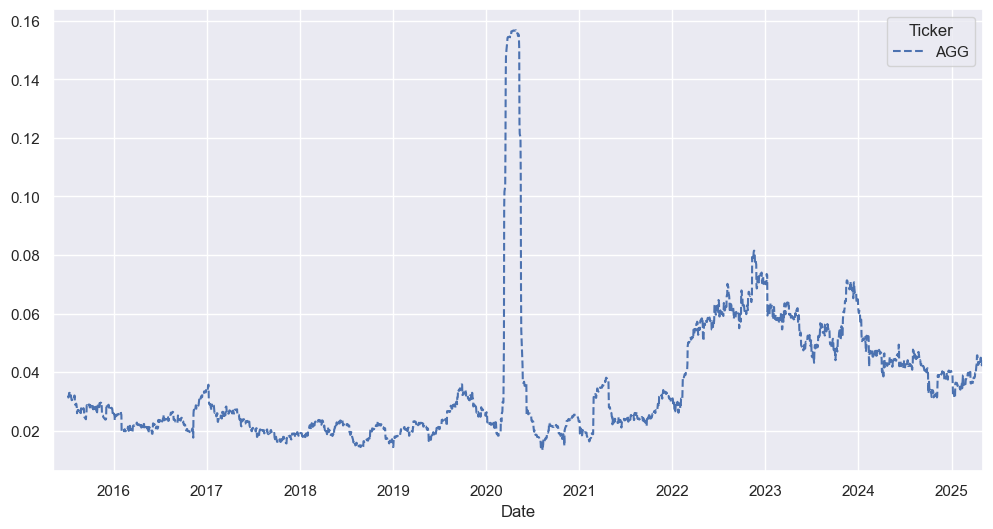

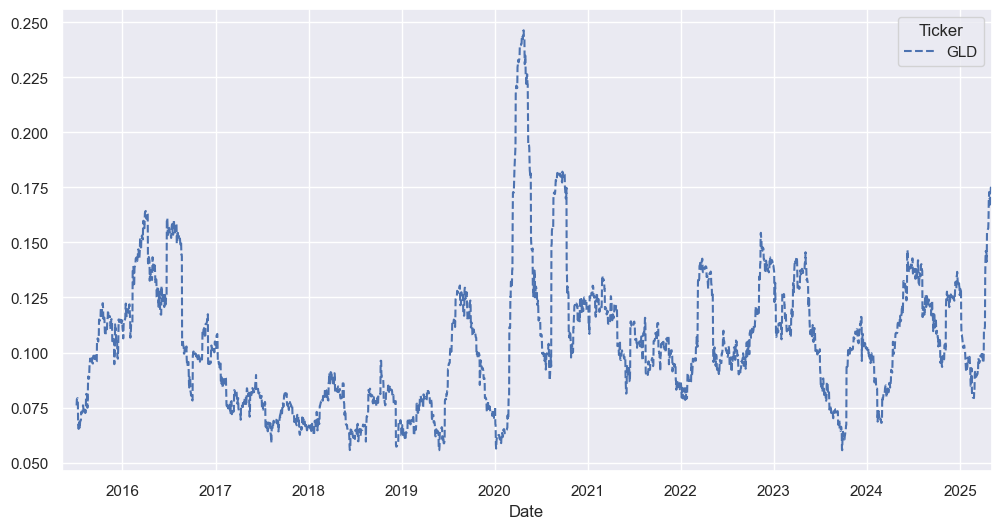

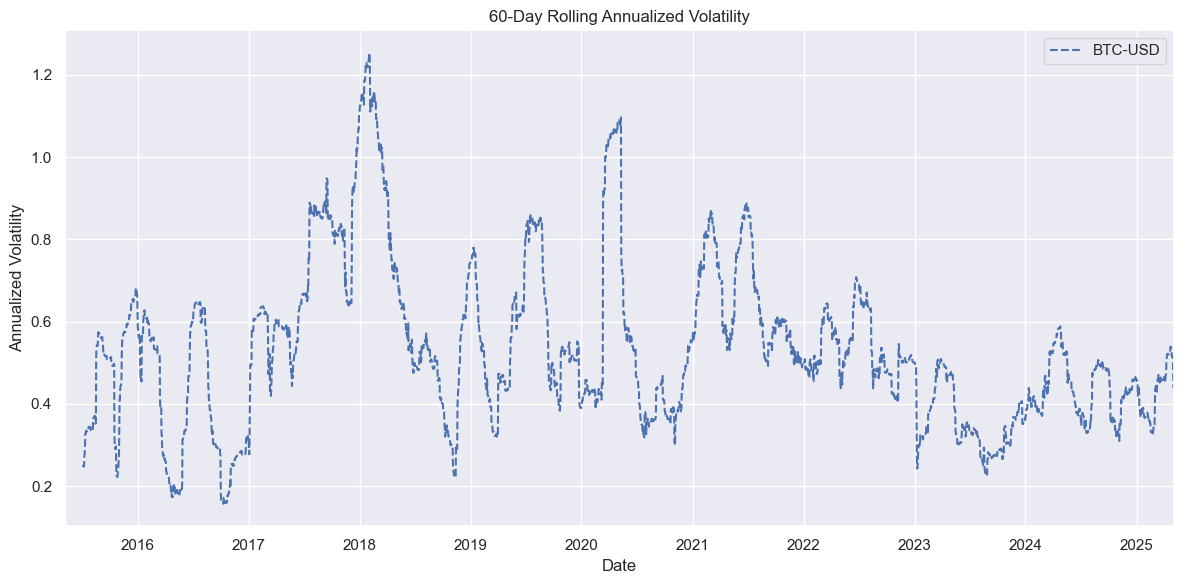

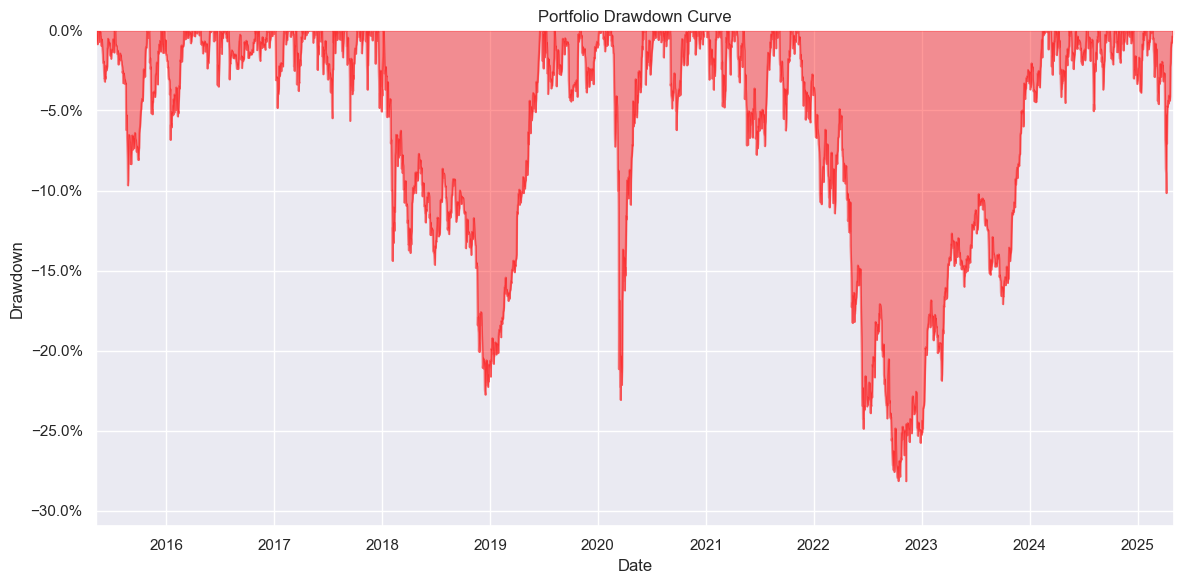


No rolling correlation data was successfully calculated or available to plot.


In [11]:

print("\n--- 6. Advanced Data Visualization ---")
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Task 6 Plot 1: Cumulative return of the portfolio over time
plt.figure()
portfolio_analysis['Cumulative Return'].plot(title='Portfolio Cumulative Return Over Time (Log Scale)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1 = Initial Investment)')
plt.yscale('log') # Log scale recommended for long-term growth plots
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Task 6 Plot 2: Heatmap of the correlation matrix with annotated coefficients
plt.figure(figsize=(max(8, n_assets * 0.8), max(6, n_assets * 0.6)))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='lightgray', annot_kws={"size": 8})
plt.title('Asset Correlation Matrix (Daily Returns)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Task 6 Plot 3: Rolling volatility of the portfolio and individual assets
window_vol = 60
rolling_portfolio_vol = portfolio_analysis['Portfolio Daily Return'].rolling(window=window_vol).std() * np.sqrt(trading_days_per_year)

plt.figure()
rolling_portfolio_vol.plot(label='Portfolio Rolling Volatility', color='black', linewidth=2)
# Add rolling vol for a few diverse assets if they exist
assets_to_plot_vol = ['SPY', 'AGG', 'GLD', 'BTC-USD']
for asset in assets_to_plot_vol:
    if asset in daily_returns.columns:
        try:
            rolling_asset_vol = daily_returns[asset].rolling(window=window_vol).std() * np.sqrt(trading_days_per_year)
            rolling_asset_vol.plot(label=f'{asset} Rolling Volatility', linestyle='--')
        except Exception as e:
            print(f"Could not plot rolling volatility for {asset}: {e}")

plt.title(f'{window_vol}-Day Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Task 6 Plot 4: Drawdown curve showing periods of loss relative to peak
plt.figure()
portfolio_analysis['Drawdown'].plot(kind='area', color='red', alpha=0.4,
                                   title='Portfolio Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown')
# Format y-axis as percentage
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.ylim(bottom=max(-1.0, portfolio_analysis['Drawdown'].min() * 1.1), top=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Rolling Correlation examples ---
# Check IF the dictionary exists and has any valid series calculated in Section 5
if 'rolling_corr_data' in locals() and rolling_corr_data:
    print("\nPlotting Rolling Correlations...")
    plt.figure()
    plotted_any = False


    for label, series in rolling_corr_data.items():
        # Check if the series object exists and contains non-NaN data before plotting
        if series is not None and isinstance(series, pd.Series) and series.notna().any():
            series.plot(label=label)
            plotted_any = True
        else:
            pass

    # Only add titles, labels, grid etc., and show the plot if something was actually plotted
    if plotted_any:
        plt.title(f'{window_corr}-Day Rolling Correlation Examples')
        plt.xlabel('Date')
        plt.ylabel('Correlation Coefficient')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.legend(loc='best')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
    else:
        # Message if no valid rolling correlation lines could be drawn
        print("  No valid rolling correlation series were available to plot.")

else:
    # Message if the dictionary wasn't created or was empty (e.g., all pairs failed calculation)
    print("\nNo rolling correlation data was successfully calculated or available to plot.")

In [12]:

print("\n--- 7. Optimization Challenge ---")

# Check for sufficient data before attempting optimization
# Need more data points than assets for stable covariance estimation
run_optimization = True
if len(daily_returns) < n_assets:
     print("\nWarning: Insufficient historical data points relative to the number of assets ")
     print(f"({len(daily_returns)} days < {n_assets} assets). Covariance matrix may be unstable.")
     print("Skipping Mean-Variance Optimization.")
     run_optimization = False

# Also check if covariance matrix is positive semi-definite
if run_optimization:
    try:
        # Calculate annualized expected returns (mu) and covariance matrix (Sigma)
        mu = daily_returns.mean() * trading_days_per_year
        Sigma = daily_returns.cov() * trading_days_per_year
        # Check for positive semi-definite Sigma (required for optimization)
        np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        print("\nWarning: Covariance matrix is not positive definite. This can happen with highly correlated assets or insufficient data.")
        print("Skipping Mean-Variance Optimization.")
        run_optimization = False
    except Exception as e:
        print(f"\nError preparing data for optimization: {e}. Skipping.")
        run_optimization = False


if run_optimization:
    # Define helper function for portfolio performance
    def get_portfolio_performance(weights, mu, Sigma, rf):
        weights = np.array(weights)
        portfolio_return = np.sum(mu * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
        if portfolio_volatility < 1e-8:
             sharpe = 0.0 if abs(portfolio_return - rf) < 1e-8 else np.inf * np.sign(portfolio_return - rf)
        else:
             sharpe = (portfolio_return - rf) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe

    # Objective function to MINIMIZE negative Sharpe ratio (i.e., maximize Sharpe)
    def negative_sharpe(weights, mu, Sigma, rf):
        return -get_portfolio_performance(weights, mu, Sigma, rf)[2]

    # Objective function to MINIMIZE volatility
    def portfolio_volatility_func(weights, mu, Sigma, rf):
         return get_portfolio_performance(weights, mu, Sigma, rf)[1]

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    # Bounds: weights between 0 and 1 (long-only portfolio)
    bounds = tuple((0.0, 1.0) for _ in range(n_assets))
    # Initial guess: equal weights
    initial_guess = np.array([1./n_assets] * n_assets)

    # --- Optimization 1: Maximize Sharpe Ratio ---
    print("\nOptimizing for Maximum Sharpe Ratio...")
    max_sharpe_result = None
    max_sharpe_weights = None
    try:
        max_sharpe_result = minimize(negative_sharpe, initial_guess,
                                     args=(mu, Sigma, avg_annualized_rf), method='SLSQP',
                                     bounds=bounds, constraints=constraints,
                                     options={'ftol': 1e-10, 'disp': False})

        if max_sharpe_result.success:
            max_sharpe_weights = max_sharpe_result.x
            max_sharpe_weights[np.abs(max_sharpe_weights) < 1e-5] = 0
            max_sharpe_weights /= np.sum(max_sharpe_weights)
            max_sharpe_perf = get_portfolio_performance(max_sharpe_weights, mu, Sigma, avg_annualized_rf)
            print("Max Sharpe Optimization Successful.")
            print("Optimized Weights:")
            opt_weights_sharpe = pd.Series(max_sharpe_weights, index=tickers)
            print(opt_weights_sharpe[opt_weights_sharpe > 1e-4].map('{:.2%}'.format))
            print(f"Expected Performance -> Return: {max_sharpe_perf[0]:.2%}, Volatility: {max_sharpe_perf[1]:.2%}, Sharpe: {max_sharpe_perf[2]:.2f}")
        else:
            print(f"Max Sharpe Optimization failed: {max_sharpe_result.message}")
    except Exception as e:
        print(f"An error occurred during Max Sharpe optimization: {e}")

    # --- Optimization 2: Minimize Volatility ---
    print("\nOptimizing for Minimum Volatility...")
    min_vol_result = None
    min_vol_weights = None
    try:
        min_vol_result = minimize(portfolio_volatility_func, initial_guess,
                                  args=(mu, Sigma, avg_annualized_rf), method='SLSQP',
                                  bounds=bounds, constraints=constraints,
                                  options={'ftol': 1e-10, 'disp': False})

        if min_vol_result.success:
            min_vol_weights = min_vol_result.x
            min_vol_weights[np.abs(min_vol_weights) < 1e-5] = 0
            min_vol_weights /= np.sum(min_vol_weights)
            min_vol_perf = get_portfolio_performance(min_vol_weights, mu, Sigma, avg_annualized_rf)
            print("Min Volatility Optimization Successful.")
            print("Optimized Weights:")
            opt_weights_minvol = pd.Series(min_vol_weights, index=tickers)
            print(opt_weights_minvol[opt_weights_minvol > 1e-4].map('{:.2%}'.format))
            print(f"Expected Performance -> Return: {min_vol_perf[0]:.2%}, Volatility: {min_vol_perf[1]:.2%}, Sharpe: {min_vol_perf[2]:.2f}")
        else:
            print(f"Min Volatility Optimization failed: {min_vol_result.message}")
    except Exception as e:
        print(f"An error occurred during Min Volatility optimization: {e}")


--- 7. Optimization Challenge ---

Optimizing for Maximum Sharpe Ratio...
Max Sharpe Optimization Successful.
Optimized Weights:
AAPL       26.55%
BTC-USD    19.99%
GLD        46.75%
JNJ         6.71%
dtype: object
Expected Performance -> Return: 19.61%, Volatility: 15.16%, Sharpe: 1.17

Optimizing for Minimum Volatility...
Min Volatility Optimization Successful.
Optimized Weights:
AGG    59.13%
JNJ     6.18%
SPY     1.89%
TIP    32.80%
dtype: object
Expected Performance -> Return: 1.75%, Volatility: 3.87%, Sharpe: -0.04


In [13]:
# --- Final Summary Section (Corresponds to Deliverable: Brief Report / Explanatory Cells) ---
# Use print statements here; add corresponding Markdown cells in your Notebook.
print("\n\n--- Analysis Summary ---")
print(f"\nThis report analyzed a portfolio of {n_assets} assets: {', '.join(tickers)}")
print(f"The analysis period covers daily data from {daily_returns.index.min().date()} to {daily_returns.index.max().date()}.")
print("Initial weights were assigned as specified and adjusted for any failed asset downloads.")

print("\nKey Findings from Historical Performance (Original Weights):")
# Refer back to the metrics_summary DataFrame or print key values again
print(metrics_summary.set_index('Metric'))
print("\nDiscussion Points:")
print("- The portfolio's overall return and risk profile can be assessed from the Annualized Return and Volatility.")
print("- The Sharpe Ratio indicates risk-adjusted performance relative to the risk-free rate.")
print("- The Maximum Drawdown highlights the largest peak-to-trough decline experienced.")

print("\nRisk Analysis Insights:")
print("- The correlation matrix shows the diversification benefits (or lack thereof) between assets.")
print("  (Lower correlations generally imply better diversification).")
print("- Rolling correlations reveal how asset relationships changed over time (e.g., during market stress).")
print("- Rolling volatility shows periods of higher and lower risk for the portfolio and key assets.")

if run_optimization and (max_sharpe_weights is not None or min_vol_weights is not None):
    print("\nOptimization Insights (Based on Historical Data):")
    if max_sharpe_weights is not None:
        print("- The Max Sharpe portfolio allocated weights to maximize historical risk-adjusted returns.")
        # Compare weights: print(" (Compare weights to original: ...)")
    if min_vol_weights is not None:
        print("- The Min Volatility portfolio allocated weights to minimize historical price fluctuations.")
        # Compare weights: print(" (Compare weights to original: ...)")
    print("- NOTE: Optimized portfolios are theoretical and based purely on past data.")
else:
    print("\nMean-Variance Optimization was not performed or completed successfully.")

print("\nImportant Limitations:")
print("- Past performance is not indicative of future results.")
print("- The analysis excludes transaction costs, taxes, and other real-world frictions.")
print("- Relies on historical data for expected returns and risk (model risk).")
print("- Assumes normally distributed returns, which may not hold true (especially for crypto).")




--- Analysis Summary ---

This report analyzed a portfolio of 10 assets: AAPL, AGG, BTC-USD, EEM, EFA, GLD, JNJ, SPY, TIP, VNQ
The analysis period covers daily data from 2015-05-08 to 2025-05-04.
Initial weights were assigned as specified and adjusted for any failed asset downloads.

Key Findings from Historical Performance (Original Weights):
                                                                           Value
Metric                                                                          
Total Cumulative Return                                                  495.54%
Annualized Return (Geometric)                                             13.11%
Annualized Volatility                                                     11.67%
Average Annualized RFR                                                     1.90%
Sharpe Ratio                                                                0.96
Maximum Drawdown                                                         -28.15%
Max 